# PyFAI Tutorial: ESRF User Meeting 2025
During the tutorial, the user can handle this notebook to follow the basic pyFAI concepts
- Importing an image
- Instantiating a detector and azimuthal integrator
- Integrate some data
- Plot the results

In [87]:
import pyFAI
import h5py
import fabio
import matplotlib.pyplot as plt
from pyFAI.gui import jupyter
print(f"We will use pyFAI version: {pyFAI.version}")

We will use pyFAI version: 2025.1.0


## 1) Detector instance: use `pyFAI.detector_factory`

#### Import the module

In [3]:
from pyFAI import detector_factory

#### We just need to know the name of the detector

In [38]:
my_detector = detector_factory(name="Eiger2_9M")

In [39]:
print(f"My detector is {my_detector.name}\nIts shape is {my_detector.shape} pixels")

My detector is Eiger2 9M
Its shape is (3262, 3108) pixels


#### Set the binning

In [76]:
my_detector.set_binning((2,2))

In [77]:
print(f"My detector is {my_detector.name}\nIts shape is {my_detector.shape} pixels")

My detector is Eiger2 9M
Its shape is (1631, 1554) pixels


## 2) Integrator:
- Use `pyFAI.integrator.azimuthal.AzimuthalIntegrator`
- Use `pyFAI.load` and a`poni` file

In [78]:
from pyFAI.integrator.azimuthal import AzimuthalIntegrator

In [93]:
ai = AzimuthalIntegrator(detector=my_detector,
                         dist=0.1, # (0.1 meters, 10cm)
                         poni1=0.05, # (5cm from the origin)
                         poni2=0.02, # (2cm from the origin)
                         wavelength=1e-10,
)

### After using `pyFAI-calib2`, we load the `poni` file

In [130]:
from pyFAI import load
file_poni = "eiger9m_bin.poni"
ai = load(filename=file_poni)
ai.detector = my_detector

In [131]:
print(f"Information from the AzimuthalIntegrator:\n\n {ai}")

Information from the AzimuthalIntegrator:

 Detector Eiger2 9M	 PixelSize= 150µm, 150µm	 BottomRight (3)
Wavelength= 3.757097e-11 m
SampleDetDist= 1.850492e-01 m	PONI= 1.300713e-01, 1.124625e-01 m	rot1=0.014603  rot2=-0.012062  rot3=0.000000 rad
DirectBeamDist= 185.082 mm	Center: x=731.734, y=852.260 pix	Tilt= 1.085° tiltPlanRotation= -140.440° 𝛌= 0.376Å


### Check where is the direct beam

In [104]:
arr_2th = ai.array_from_unit(unit="2th_deg")

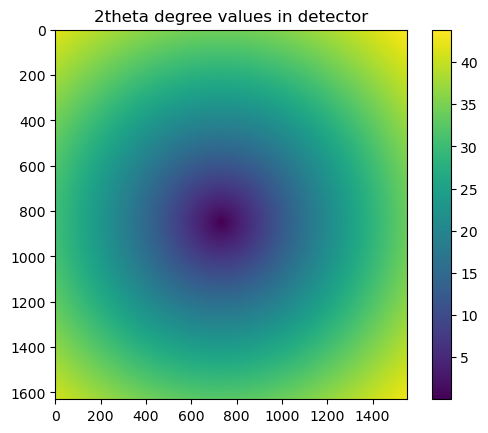

In [105]:
fig, ax = plt.subplots()
img = ax.imshow(arr_2th, cmap="viridis")
fig.colorbar(img)
ax.set_title("2theta degree values in detector")
pass

### Novelty in `pyFAI 2025.01`: `FiberIntegrator`

In [132]:
fiber_integrator = load(filename=file_poni, 
                        type_="pyFAI.integrator.fiber.FiberIntegrator",
)

In [133]:
print(f"Information from the FiberIntegrator:\n\n {fiber_integrator}")

Information from the FiberIntegrator:

 Detector Eiger2 9M	 PixelSize= 75µm, 75µm	 BottomRight (3)
Wavelength= 3.757097e-11 m
SampleDetDist= 1.850492e-01 m	PONI= 1.300713e-01, 1.124625e-01 m	rot1=0.014603  rot2=-0.012062  rot3=0.000000 rad
DirectBeamDist= 185.082 mm	Center: x=1463.468, y=1704.519 pix	Tilt= 1.085° tiltPlanRotation= -140.440° 𝛌= 0.376Å
Incident angle: 0.00° Tilt angle 0.00° Sample orientation 1


## 3) Load `.h5` data with `h5py`

In [108]:
with h5py.File(name="Eiger2_bin2_CeO2_33keV.h5", mode="r") as f:
    data = f["/entry_0000/measurement/data"][0]

#### Plot the data with `matplotlib`

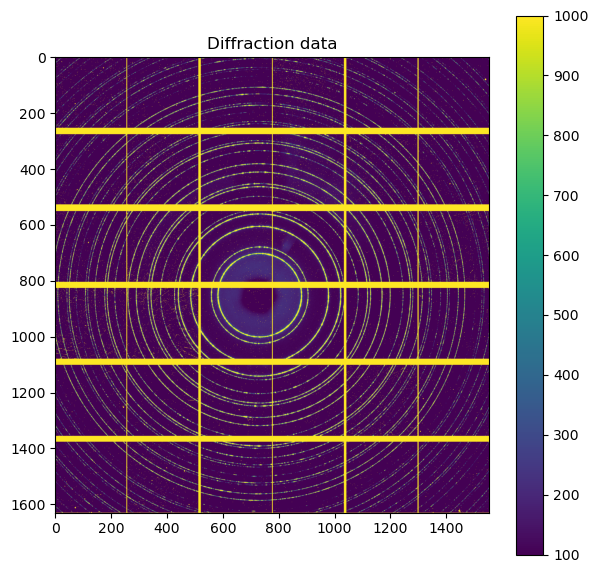

In [109]:
fig, ax = plt.subplots(figsize=(7,7))
img = ax.imshow(data, cmap="viridis", vmin=100, vmax=1000)
fig.colorbar(img)
ax.set_title("Diffraction data")
pass

## 4) Integration:
- `integrate1d`
- `integrate2d`

### 1-dimensional integration: for powder diffraction, WAXS, SAXS..

In [110]:
result_1d = ai.integrate1d(data=data,
                           npt=2000, # Only mandatory parameter with the data: radial bins
                          )

#### Plot the result with `pyFAI.gui.jupyter`

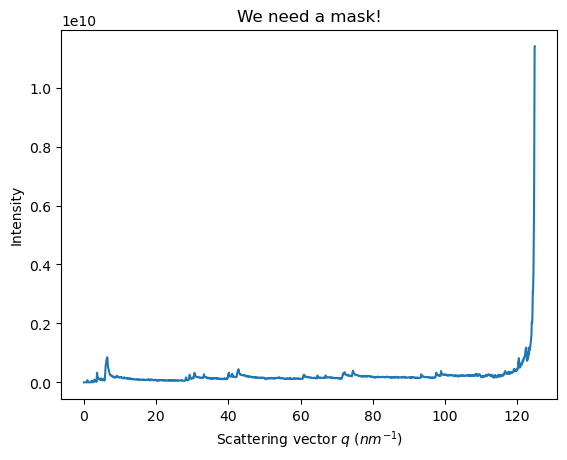

In [111]:
fig, ax = plt.subplots()
jupyter.plot1d(result=result_1d,
               ax=ax,
)
ax.set_title("We need a mask!")
pass

### Import the mask with FabIO package

In [125]:
mask = fabio.open("eiger9_mask.edf").data
result_1d_masked = ai.integrate1d(data=data,
                                  npt=1000,
                                  mask=mask,
                                  radial_range=[10,100],
                                 )

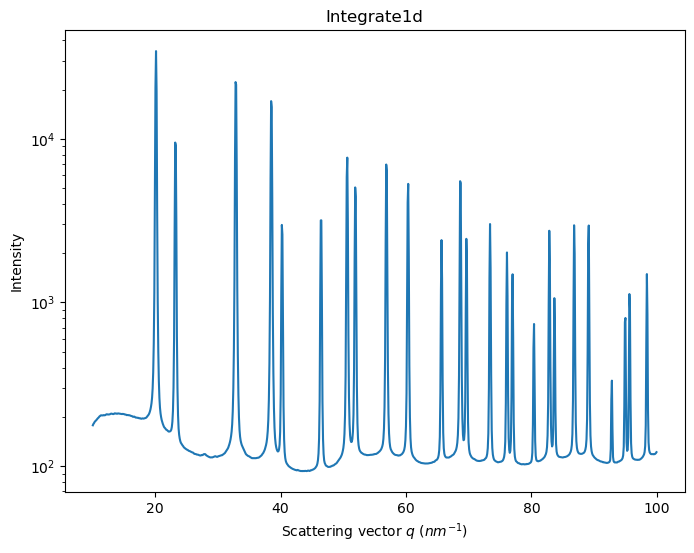

In [126]:
fig, ax = plt.subplots(figsize=(8,6))
jupyter.plot1d(result=result_1d_masked,
               ax=ax,
)
ax.set_title("Integrate1d")
ax.set_yscale("log")
pass

### 2-Dimensional integration: for textured scattering, single crystal diffraction...

In [117]:
result_2d_masked = ai.integrate2d(data=data,
                                  npt_rad=1000,
                                  npt_azim=360,
                                  mask=mask,
                                 )

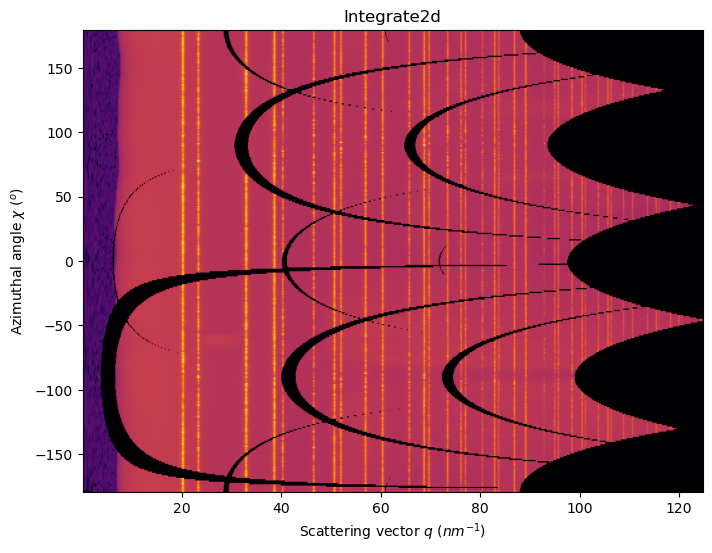

In [136]:
fig, ax = plt.subplots(figsize=(8,6))
jupyter.plot2d(result=result_2d_masked,
               ax=ax,
)
ax.set_title("Integrate2d")
pass